首先导入必要的python包

注意：如果报错`缺失punkt`的话，把`nltk.download('punkt')`取消注释即可。

可能需要预先安装的包：

```bash
pip install vocabulary
pip install nltk
pip install -U requests                     # 这里是因为前面安装vocabulary包会导致requests起一些冲突，建议再安装一次
pip install rouge
```

In [4]:
import nltk
import os
import torch
import torch.utils.data as data
from vocabulary.vocabulary import Vocabulary
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
import json
from collections import defaultdict, Counter
from PIL import Image
from matplotlib import pyplot as plt
import nltk
# nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 数据处理部分，分开处理训练集和测试集

In [5]:
import os
import json
import random
from collections import defaultdict, Counter
from PIL import Image
from matplotlib import pyplot as plt

def create_dataset(dataset='deepfashion',
                   captions_per_image=1,
                   min_word_count=1,
                   max_len=80) -> str:
    """
    params:
        dataset: dataset path
        captions_per_image: captions amount for each image
        min_word_count: the minimum word count threshold
        max_len: max length of caption
    output:
        vocab.json
        train_data.json, val_data.json, test_data.json
    """ 
    train_data_json_path = '../dataset/deepfashion-multimodel/train_captions.json'
    test_data_json_path = '../dataset/deepfashion-multimodel/test_captions.json'
    image_folder = '../dataset/deepfashion-multimodel/images/'
    output_folder = '../output/' 
    
    # add additional check to avoid wasting time on processing dataset.
    if os.path.exists(output_folder):
        files = os.listdir(output_folder)
        if 'vocab.json' in files and 'train_data.json' in files and 'test_data.json' in files:
            print('Dataset already exists. Skipping processing.')
            return output_folder
    else:
        os.makedirs(output_folder)

    with open(train_data_json_path, 'r') as j:
        data = json.load(j)

    image_paths = []
    image_captions = []
    vocab = Counter()
    # push the captions into vocab
    for k,v in data.items():
        tokens = nltk.tokenize.word_tokenize(v.lower())
        vocab.update(tokens)
        path = os.path.join(image_folder,k)
        image_paths.append(path)
        if len(tokens) <= max_len:
            image_captions.append(tokens)
        elif len(tokens) > max_len:
            tokens=tokens[0:max_len]
            image_captions.append(tokens)
        if len(tokens) == 0:
            continue

    # create vocab
    words = [w for w in vocab.keys() if vocab[w] >= min_word_count]
    vocab = {k: v + 1 for v, k in enumerate(words)}
    vocab['<pad>'] = 0
    vocab['<unk>'] = len(vocab)
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)

    # store vocab
    with open(os.path.join(output_folder, 'vocab.json'), 'w') as fw:
        json.dump(vocab, fw)

    # clean up captions
    enc_captions = []
    for j, c in enumerate(image_captions):
        # encode the captions according to vocab
        enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']]
        enc_captions.append(enc_c)

    assert len(image_paths) * captions_per_image == len(enc_captions)

    for i, path in enumerate(image_paths):
        # check if the image can be resolved
        img = Image.open(path)

    
    data = {'IMAGES': image_paths,
            'CAPTIONS': enc_captions}
    with open(os.path.join(output_folder, 'train_data.json'), 'w') as fw:
        json.dump(data, fw)

    with open(test_data_json_path, 'r') as t:
        test_data = json.load(t)

    test_image_paths = []
    test_image_captions = []

    for k,v in test_data.items():
        tokens=nltk.tokenize.word_tokenize(v.lower())
        path = os.path.join(image_folder,k)
        test_image_paths.append(path)
        if len(tokens) <= max_len:
            test_image_captions.append(tokens)
        elif len(tokens) > max_len :
            tokens=tokens[0:max_len]
            test_image_captions.append(tokens)
        if len(tokens) == 0:
            continue

    test_enc_captions = []
    for j, c in enumerate(test_image_captions):
        enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']]
        test_enc_captions.append(enc_c)


    assert len(image_paths) * captions_per_image == len(enc_captions)

    for i, path in enumerate(image_paths):
        img = Image.open(path)

    testdata = {'IMAGES': test_image_paths,
            'CAPTIONS': test_enc_captions}
    with open(os.path.join(output_folder, 'test_data.json'), 'w') as fw:
        json.dump(testdata, fw)
        
    return output_folder
output_folder = create_dataset()

Dataset already exists. Skipping processing.


对上方的数据集初步处理结果进行简单的验证

具体验证思路仿造案例：

随机读取图像、查看图像，查看图像对应的caption

[107, 36, 40, 4, 73, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 4, 33, 44, 15, 14, 1, 50, 1, 45, 26, 18, 16, 5, 21, 14, 1, 50, 47, 29, 8, 9, 10, 11, 12, 13, 14, 108]
<start> this female is wearing a sleeveless tank top with floral patterns and a three-point pants . the tank top is with cotton fabric and its neckline is v-shape . the pants are with cotton fabric and floral patterns . the lady is wearing a ring on her finger . the person is wearing a hat . there is an accessory on her wrist . <end>


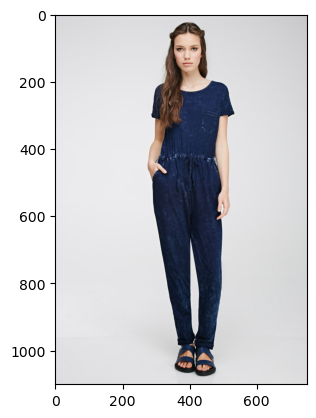

In [6]:
# read vocab and datas
with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word,idx in vocab.items()}
with open(os.path.join(output_folder, 'train_data.json'), 'r') as f:
    data = json.load(f)
with open(os.path.join(output_folder, 'test_data.json'), 'r') as k:
    testdata = json.load(k)

# show the 12th data
# show image
content_img = Image.open(data['IMAGES'][11])
plt.imshow(content_img)

# show token_ids and tokens
print(data['CAPTIONS'][11])
print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][12]]))

构建dataset类，便于后续dataloader的构建

在此处，我们创建`ImageCaption` 数据集，`getitem`内部函数返回三个值：

+ image: PIL.Image
+ caption: str
+ cap_len: int

In [7]:
from argparse import Namespace
import numpy as np
import os
import json
from PIL import Image
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

class ImageCaptionDataset(Dataset):
    def __init__(self, 
                 dataset_path: str, 
                 vocab_path: str, 
                 split: str,    # the choice in {'train', 'test'}
                 captions_per_image: int=1, 
                 max_len: int=80, 
                 transform=None):
        self.split = split
        assert self.split in {'train', 'test'}
        self.cpi = captions_per_image
        self.max_len = max_len

        # load the json files
        with open(dataset_path, 'r') as f:
            self.data = json.load(f)
        with open(vocab_path, 'r') as f:
            self.vocab = json.load(f)

        # process the images for further forward computing
        self.transform = transform

        # Total number of data points
        self.dataset_size = len(self.data['CAPTIONS'])

    def __getitem__(self, i):
        # 第i个文本描述对应第(i // captions_per_image)张图片
        img = Image.open(self.data['IMAGES'][i]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        caplen = len(self.data['CAPTIONS'][i])
        caption = torch.LongTensor(self.data['CAPTIONS'][i]+ [self.vocab['<pad>']] * (self.max_len + 2 - caplen))

        return img, caption, caplen


    def __len__(self):
        return self.dataset_size

仿：定义`mktrainval`函数，返回train_dataloader和test_dataloader

这一步需要使用上方的`ImageCaptionDataset`类

In [8]:
def mktrainval(data_dir, vocab_path, batch_size, workers=4):
    train_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_set = ImageCaptionDataset(os.path.join(data_dir, 'train_data.json'),
                                 vocab_path, 
                                 split='train',  
                                 transform=train_tx)
    test_set = ImageCaptionDataset(os.path.join(data_dir, 'test_data.json'),
                                 vocab_path, 
                                 split='test', 
                                 transform=val_tx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, test_loader


### CNN Encoder实现

+ 使用`Resnet101`提取网格特征
+ 而后，通过池化、展平的操作，转化为全连接层，从而得到全局的特征。

In [9]:
import torchvision.models as models
import torch.nn as nn

class ImageEncoder(nn.Module):
    def __init__(self, finetuned=True, output_dim=2048):
        super(ImageEncoder, self).__init__()
        
        # first we adopt the pretrained resnet101 model
        model = models.resnet101(pretrained=True)
        self.feature_extractor = nn.Sequential(*(list(model.children())[:-2]))
        
        # globally average pool the feature maps
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # convert the features into a 1D vector (full connected layer)
        self.fc = nn.Linear(2048, output_dim)

        # set the params to be finetuned or not
        for param in self.feature_extractor.parameters():
            param.requires_grad = finetuned

    def forward(self, images):
        features = self.feature_extractor(images)       # (batch_size, 2048, H, W)
        pooled = self.avg_pool(features)                # (batch_size, 2048, 1, 1)
        flattened = pooled.view(pooled.size(0), -1)     # (batch_size, 2048)
        out = self.fc(flattened)                        # (batch_size, output_dim)
        return out

### GRU Decoder实现
定义GRU_Decoder类：这是一个自定义的PyTorch模型，用于生成图像标注。

+ self.embed: 创建一个嵌入层，用于将词汇表中的单词索引转换为固定大小的词向量。
+ self.init_state: 创建一个线性层，用于将图像编码转换为GRU的初始状态。
+ self.rnn: 创建一个GRU层，用于处理词嵌入和图像编码的序列数据。
+ self.dropout: 创建一个Dropout层，用于正则化。
+ self.fc: 创建一个线性层，用于将GRU的输出转换为最终的词汇表预测。
+ self.init_weights: 初始化嵌入层和线性层的权重和偏置。
+ init_hidden_state方法：该方法用于初始化隐藏状态，将输入的图像编码和标注排序后的数据准备成模型所需的形状。

In [10]:
import torch
from torch import nn
import numpy as np

class GRU_Decoder(nn.Module):
    def __init__(self, 
                 image_code_dim: int, 
                 vocab_size: int, 
                 word_dim: int, 
                 hidden_size: int, 
                 num_layers: int, 
                 dropout=0.5):
        super(GRU_Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, word_dim) 
        self.init_state = nn.Linear(image_code_dim, num_layers*hidden_size)
        self.rnn = nn.GRU(word_dim+image_code_dim, hidden_size, num_layers)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, image_code, captions, cap_lens):
        batch_size, image_code_dim = image_code.size(0), image_code.size(1)

        sorted_cap_lens, sorted_cap_indices = torch.sort(cap_lens, 0, True)
        captions = captions[sorted_cap_indices]
        image_code = image_code[sorted_cap_indices]

        hidden_state = self.init_state(image_code)      #(batch_size, image_code_dim)
        hidden_state = hidden_state.view(
                            batch_size,
                            self.rnn.num_layers,
                            self.rnn.hidden_size).permute(1, 0, 2)  #(num_layers,batch_size,hidden_size)
        return image_code, captions, sorted_cap_lens, sorted_cap_indices, hidden_state

    def forward_step(self,image_code, curr_cap_embed, hidden_state):
        gru_input = torch.cat((curr_cap_embed, image_code), dim=1).unsqueeze(0)
        out, hidden_state = self.rnn(gru_input, hidden_state)
        preds = self.fc(self.dropout(out.squeeze(0)))
        return preds, hidden_state

    def forward(self, image_code, captions, cap_lens):
        image_code, captions, sorted_cap_lens, sorted_cap_indices, hidden_state \
            = self.init_hidden_state(image_code, captions, cap_lens)
        batch_size = image_code.size(0)
        lengths = sorted_cap_lens.cpu().numpy() - 1
        predictions = torch.zeros(batch_size, lengths[0], self.fc.out_features).to(captions.device)
        cap_embeds = self.embed(captions)
        
        for step in range(lengths[0]):
            real_batch_size = np.where(lengths > step)[0].shape[0]
            preds, hidden_state = self.forward_step(
                            image_code[:real_batch_size],
                            cap_embeds[:real_batch_size, step, :],
                            hidden_state[:, :real_batch_size, :].contiguous())
            predictions[:real_batch_size, step, :] = preds
        return predictions, captions, lengths, sorted_cap_indices

### 实现整体网络
现在开始一个CNN + GRU整体的网络

In [11]:
class CNNGRUNet(nn.Module):
    def __init__(self, image_code_dim, vocab, word_dim, hidden_size, num_layers):
        super(CNNGRUNet,self).__init__()
        self.encoder = ImageEncoder()
        self.decoder = GRU_Decoder(image_code_dim, len(vocab), word_dim, hidden_size, num_layers)
        self.vocab = vocab
        
    def forward(self, images, captions, cap_lens):
        image_features = self.encoder(images)
        output = self.decoder(image_features, captions, cap_lens)
        return output
    
    def generate(self, images, beam_k, max_len):
        vocab_size = len(self.vocab)
        image_codes = self.encoder(images)
        texts = []
        device = images.device
        
        # beamsearch for each image
        for image_code in image_codes:
            gen_sent = self._beam_search(image_code, beam_k, max_len, vocab_size)
            texts.append(gen_sent)
        return texts
    
    def _beam_search(self, image_code, beam_k, max_len, vocab_size):
        # make `k` copies for a image
        image_code = image_code.unsqueeze(0).repeat(beam_k,1)       #  (5，2048)
        # generate k sentences
        cur_sents = torch.full((beam_k, 1), self.vocab['<start>'], dtype=torch.long).to(device)
        cur_sent_embed = self.decoder.embed(cur_sents)[:,0,:]
        sent_lens = torch.LongTensor([1]*beam_k).to(device)

        image_code, cur_sent_embed, _, _, hidden_state = \
            self.decoder.init_hidden_state(image_code, cur_sent_embed, sent_lens)

        # store generated sentences
        end_sentences = []
        end_probs = []
        probs = torch.zeros(beam_k, 1).to(device)
        k = beam_k
        while True:
            preds, hidden_state = self.decoder.forward_step(image_code[:k], cur_sent_embed, hidden_state.contiguous())
            preds = nn.functional.log_softmax(preds, dim=1)

            probs = probs.repeat(1,preds.size(1)) + preds
            if cur_sents.size(1) == 1:
                values, indices = probs[0].topk(k, 0, True, True)
            else:
                # convert to 1D
                values, indices = probs.view(-1).topk(k, 0, True, True)

            sent_indices = torch.div(indices, vocab_size, rounding_mode='trunc')
            word_indices = indices % vocab_size

            cur_sents = torch.cat([cur_sents[sent_indices], word_indices.unsqueeze(1)], dim=1)

            end_indices = [idx for idx, word in enumerate(word_indices) if word == self.vocab['<end>']]
            if len(end_indices) > 0:
                end_probs.extend(values[end_indices])
                end_sentences.extend(cur_sents[end_indices].tolist())

                k -= len(end_indices)
                if k == 0:
                    break

            cur_indices = [idx for idx, word in enumerate(word_indices)
                            if word != self.vocab['<end>']]
            if len(cur_indices) > 0:
                cur_sent_indices = sent_indices[cur_indices]
                cur_word_indices = word_indices[cur_indices]

                cur_sents = cur_sents[cur_indices]
                probs = values[cur_indices].view(-1,1)
                hidden_state = hidden_state[:,cur_sent_indices,:]
                cur_sent_embed = self.decoder.embed(
                    cur_word_indices.view(-1,1))[:,0,:]

            if cur_sents.size(1) >= max_len:
                break
        if len(end_sentences) == 0:
            generate_sentence = cur_sents[0].tolist()
        else:
            generate_sentence = end_sentences[end_probs.index(max(end_probs))]
            
        return generate_sentence
        
        

针对该任务，我们需要自己手写一个交叉熵

这个交叉熵损失函数基于torch.module制作，主要是将输出的内容pack起来，然后再计算loss

In [12]:
class PackedCELoss(nn.Module):
    def __init__(self):
        super(PackedCELoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, predictions, targets, lengths):
        predictions = pack_padded_sequence(predictions, lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, lengths, batch_first=True)[0]
        return self.loss_fn(predictions, targets)


In [13]:
def get_optimizer(model, config):
    return torch.optim.Adam([{"params": filter(lambda p: p.requires_grad, model.encoder.parameters()),
                              "lr": config.encoder_learning_rate},
                             {"params": filter(lambda p: p.requires_grad, model.decoder.parameters()),
                              "lr": config.decoder_learning_rate}])

def adjust_learning_rate(optimizer, epoch, config):
    """
        adjust the learning rate manually
    """
    optimizer.param_groups[0]['lr'] = config.encoder_learning_rate * (0.1 ** (epoch // config.lr_update))
    optimizer.param_groups[1]['lr'] = config.decoder_learning_rate * (0.1 ** (epoch // config.lr_update))

实现BELU评估 （BELU4）

In [14]:
from nltk.translate.bleu_score import corpus_bleu

def filter_useless_words(sent, filterd_words):
    return [w for w in sent if w not in filterd_words]

def evaluate_BELU4(data_loader, model, config):
    model.eval()
    
    candidates, refences = [], []
    
    filterd_words = set({model.vocab['<start>'], model.vocab['<end>'], model.vocab['<pad>']})
    cpi = config.captions_per_image
    device = next(model.parameters()).device
    for i, (imgs, caps, caplens) in enumerate(data_loader):
        with torch.no_grad():
            texts = model.generate(imgs.to(device), config.beam_k, config.max_len+2)

            candidates.extend([filter_useless_words(text, filterd_words) for text in texts])

            refences.extend([filter_useless_words(cap, filterd_words) for cap in caps.tolist()])
   
    multiple_refs = []
    for idx in range(len(refences)):
        multiple_refs.append(refences[(idx//cpi)*cpi : (idx//cpi)*cpi+cpi])

    bleu4 = corpus_bleu(multiple_refs, candidates, weights=(0.25,0.25,0.25,0.25))
    model.train()
    return bleu4

实现METEOR评估

In [15]:
import json
import torch
from nltk.translate.meteor_score import single_meteor_score

def evaluate_meteor(data_loader, model, config):
    model.eval()
    cands = []
    refs = []
    filterd_words = set({'<start>', '<end>', '<pad>'})
    device = next(model.parameters()).device

    with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}

    for i, (imgs, caps, caplens) in enumerate(data_loader):
        with torch.no_grad():
            texts = model.generate(imgs.to(device), config.beam_k, config.max_len+2)
            # 解码生成的文本
            decoded_texts = [' '.join([vocab_idx2word[word_idx] for word_idx in text]) for text in texts]
            # 过滤不必要的词
            filtered_texts = [' '.join(filter_useless_words(text.split(), filterd_words)) for text in decoded_texts]
            cands.extend(filtered_texts)
            
            # 解码并过滤参考文本
            for cap in caps.tolist():
                decoded_cap = ' '.join([vocab_idx2word[word_idx] for word_idx in cap if word_idx in vocab_idx2word])
                filtered_cap = ' '.join(filter_useless_words(decoded_cap.split(), filterd_words))
                refs.append(filtered_cap)

    # 计算METEOR
    meteor_score = 0
    for cand, ref in zip(cands, refs):
        meteor_score += single_meteor_score(ref.split(), cand.split())

    meteor_score /= len(cands)
    model.train()
    return meteor_score

实现ROUGE-L评估

In [16]:
from rouge import Rouge

def evaluate_Rouge_L(data_loader, model, config):
    model.eval()
    cands = []
    refs = []
    decoded_caps = []
    filterd_words = set({'<start>', '<end>', '<pad>'})
    device = next(model.parameters()).device

    with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}

    for i, (imgs, caps, caplens) in enumerate(data_loader):
        with torch.no_grad():
            texts = model.generate(imgs.to(device), config.beam_k, config.max_len+2)
            decoded_texts = [' '.join([vocab_idx2word[word_idx] for word_idx in text]) for text in texts]
            filtered_texts = [' '.join(filter_useless_words(text.split(), filterd_words)) for text in decoded_texts]
            cands.extend(filtered_texts)
            
            for cap in caps.tolist():
                decoded_cap = ' '.join([vocab_idx2word[word_idx] for word_idx in cap if word_idx in vocab_idx2word])
                filtered_cap = ' '.join(filter_useless_words(decoded_cap.split(), filterd_words))
                refs.append(filtered_cap)
                
    rouge_evaluator = Rouge(metrics=['rouge-l'])

    scores = rouge_evaluator.get_scores(cands, refs, avg=True) 
    rouge_l_score = scores['rouge-l']['f']  

    model.train()
    return rouge_l_score

组织训练逻辑，并且开始训练

In [17]:
from tqdm import tqdm

# set up the basic config for training
config = Namespace(
    max_len = 80,
    captions_per_image = 1,
    batch_size = 32,
    image_code_dim = 2048,
    word_dim = 512,
    hidden_size = 512,
    num_layers = 1,
    encoder_learning_rate = 0.0001,
    decoder_learning_rate = 0.0005,
    num_epochs = 3,
    grad_clip = 5.0,
    alpha_weight = 1.0,
    evaluate_step = 150, 
    checkpoint = None, 
    beam_k = 5
)


print(device)

data_dir = output_folder
vocab_path = os.path.join(data_dir, 'vocab.json')
train_loader, test_loader = mktrainval(data_dir, vocab_path, config.batch_size)


with open(vocab_path, 'r') as f:
    vocab = json.load(f)


start_epoch = 0
checkpoint = config.checkpoint
if checkpoint is None:
    model = CNNGRUNet(config.image_code_dim, vocab, config.word_dim, config.hidden_size, config.num_layers)

else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']

optimizer = get_optimizer(model, config)

model.to(device)
model.train()


loss_fn = PackedCELoss().to(device)

best_res = 0
print("start training")

ckpt_path = os.path.join(output_folder, 'model_ckpt/cnngru')

if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)

for epoch in range(start_epoch, config.num_epochs):
    print("Training on epoch ", epoch)
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{config.num_epochs}', unit='batch') as pbar:
        for i, (imgs, caps, caplens) in enumerate(train_loader):
            optimizer.zero_grad()
            
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)
            
            predictions, sorted_captions, lengths, sorted_cap_indices = model(imgs, caps, caplens)
            loss = loss_fn(predictions, sorted_captions[:, 1:], lengths)

            loss.backward()
            if config.grad_clip > 0:
                nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)

            optimizer.step()
            
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())

            state = {
                    'epoch': epoch,
                    'step': i,
                    'model': model,
                    'optimizer': optimizer
                    }

            if (i+1) % config.evaluate_step == 0:        
                print("Validating on test set")
                bleu_score = evaluate_BELU4(test_loader, model, config)
                if best_res < bleu_score:
                    best_res = bleu_score
                    torch.save(model.state_dict(), os.path.join(ckpt_path, 'best_CRmodel.pth'))
                torch.save(model.state_dict(), os.path.join(ckpt_path, 'current_CRmodel.pth'))
                print('Validation@epoch, %d, step, %d, BLEU-4=%.2f\n' %
                    (epoch, i+1, bleu_score))

        
model.load_state_dict(torch.load(os.path.join(ckpt_path, 'best_CRmodel.pth')))
model.eval()
bleu_score = evaluate_BELU4(test_loader, model, config)

print("Evaluate on the test set with the model that has the best performance on the validation set")
print('Epoch: 1, BLEU-4=%.2f' % bleu_score)

cuda


/home/airaiot/miniconda3/envs/adapter/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/airaiot/miniconda3/envs/adapter/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


start training
Training on epoch  0


Epoch 1/3:  47%|████▋     | 150/318 [00:32<00:35,  4.78batch/s, loss=0.664]

Validating on test set


Epoch 1/3:  47%|████▋     | 150/318 [01:25<01:35,  1.76batch/s, loss=0.664]


KeyboardInterrupt: 

### 结果验证可视化，选取了测试集的第一张照片作为输入，用网络的beamsearch函数寻找概率最高的句子，并用构建的词表vocab解码

generated text is [[107, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1, 15, 16, 1, 39, 48, 18, 29, 8, 9, 10, 64, 15, 18, 32, 33, 34, 35, 36, 37, 14, 108]]
decode text is <start> the upper clothing has long sleeves , cotton fabric and solid color patterns . the neckline of the tank top is with cotton fabric and its neckline is wearing a ring on her finger . <end>
METEOR=0.54
ROUGE-L=0.64


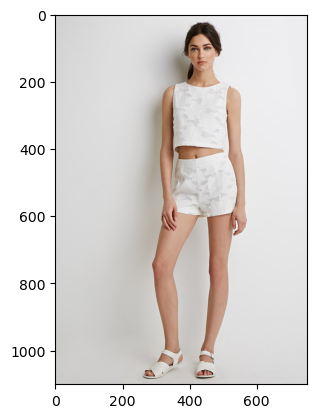

In [18]:
import torchvision.transforms as transforms

config = Namespace(
    max_len = 80,
    captions_per_image = 1,
    batch_size = 32,
    image_code_dim = 2048,
    word_dim = 512,
    hidden_size = 512,
    num_layers = 1,
    encoder_learning_rate = 0.0001,
    decoder_learning_rate = 0.0005,
    num_epochs = 2,
    grad_clip = 5.0,
    alpha_weight = 1.0,
    evaluate_step = 300, 
    checkpoint = None, 
    beam_k = 5
)

model = CNNGRUNet(config.image_code_dim, vocab, config.word_dim,config.hidden_size, config.num_layers)
model.load_state_dict(torch.load(os.path.join(ckpt_path, 'best_CRmodel.pth')))
model = model.to(device)
model.eval()

with open(os.path.join(output_folder, 'vocab.json'), 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word,idx in vocab.items()}

with open(os.path.join(output_folder, 'test_data.json'), 'r') as t:
    test = json.load(t)
    
img = Image.open(test['IMAGES'][0]).convert('RGB')  
plt.imshow(img) 
transform = transforms.Compose([transforms.ToTensor()])
img = transform(img).unsqueeze(0)

img = img.to(device)

with torch.no_grad():
    generated_text=model.generate(img, 5, 50)
print("generated text is", generated_text)
for text in generated_text:
    print("decode text is",' '.join([vocab_idx2word[word_idx] for word_idx in text]))
    
meteor_score = evaluate_meteor(test_loader, model, config)
rouge_l_score = evaluate_Rouge_L(test_loader, model, config)

print('METEOR=%.2f' % meteor_score)
print('ROUGE-L=%.2f' % rouge_l_score)
